# Generation and debugging script for the Multi Channel Speech Enhancement Dataset

In [77]:
import numpy as np
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython
import os
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

## Split the source datas for train and val

In [ ]:
# load all clean speeches
clean_root = '/data2/zhouchang/datasets/datasets_fullband/clean_fullband/read_speech'
clean_records = os.listdir(clean_root)
clean_records.sort()
print(len(clean_records))

# split train and val clean speeches set
data_split = {'train':20,'val':1}
n_clean_train = int(len(clean_records)*data_split['train']/sum(data_split.values()))

rs = np.random.RandomState(123)

rs.shuffle(clean_records)
cleans_train = clean_records[:n_clean_train]
cleans_val = clean_records[n_clean_train:]
print(f'clean train:val = {len(cleans_train)}:{len(cleans_val)}')

# load all noises
noise_root = '/data2/zhouchang/datasets/datasets_fullband/noise_fullband'
noise_records = os.listdir(noise_root)
noise_records.sort()
print(len(noise_records))

# split train and val noise speeches set
n_noise_train = int(len(noise_records)*data_split['train']/sum(data_split.values()))

rs.shuffle(noise_records)
noises_train = noise_records[:n_noise_train]
noises_val = noise_records[n_noise_train:]
print(f'noise train:val = {len(noises_train)}:{len(noises_val)}')

# write to files
with open('/data2/zhouchang/datasets/datasets_fullband/cleans_train', 'w') as f:
    for x in cleans_train:
        f.write(x+'\n')
with open('/data2/zhouchang/datasets/datasets_fullband/noises_train', 'w') as f:
    for x in noises_train:
        f.write(x+'\n')

In [ ]:
fs, clean = wavfile.read(os.path.join(clean_root,cleans_val[0]))
print(fs,clean.dtype)
IPython.display.display(IPython.display.Audio(clean, rate=fs))
fs, noise = wavfile.read(os.path.join(noise_root,noises_val[0]))
IPython.display.display(IPython.display.Audio(noise , rate=fs))

## Sample generation play ground



In [78]:
import json
with open('mcse_dataset_settings.json','r') as f:
    opt = json.load(f)
fs = opt['audio']['fs']

{'room_dim': array([8.33785001, 7.55773048, 2.80752596]), 'e_absorption': 0.21337792194291044, 'max_order': 80, 'fs': 16000, 'p_mics': array([[4.90118708, 4.9031886 , 4.91579842, 4.92840825, 4.94101808,
        4.87596742, 4.88857725, 4.91379691],
       [4.2009221 , 4.13386992, 4.1610911 , 4.18831227, 4.21553344,
        4.14647975, 4.17370093, 4.22814327],
       [1.11123302, 1.11123302, 1.11123302, 1.11123302, 1.11123302,
        1.11123302, 1.11123302, 1.11123302]]), 'p_target': array([2.23361653, 5.4201056 , 1.32476132]), 'p_noise_list': [array([4.97554869, 5.01584817, 1.06264947]), array([3.1799097 , 4.15093562, 1.32359861]), array([1.75312254, 7.20117309, 1.35381791])], 'snr_list': [1.1130040546061082, -0.612655300384743, -1.6128231011690142], 'dBFS': -28.810534991455047, 'clean': 'book_08463_chp_0002_reader_01375_21.wav', 'noises': array(['1mEYMdHfCyc.wav', '2BBfdEQE1x0.wav', 'sFHoljcCBSI.wav'],
      dtype='<U95')}


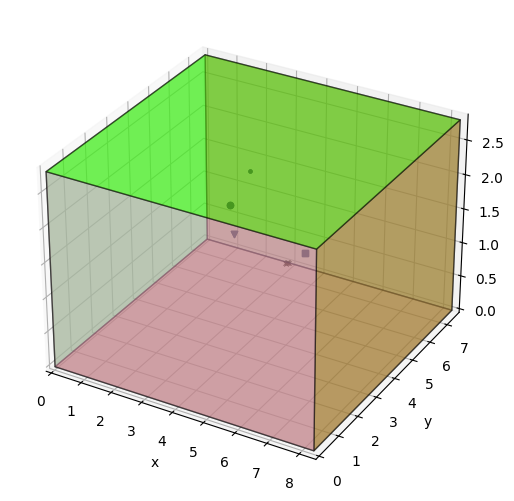

In [88]:
from mcse_dataset import generate_random_noisy_for_speech

sample = generate_random_noisy_for_speech(opt, 8, cleans_val[0], noises_val, clean_root, noise_root)
meta = sample['meta']
room = sample['room']
freefield = sample['freefield']
noisy = sample['noisy']
clean = sample['clean']
fig, ax = room.plot(img_order=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
print(meta)

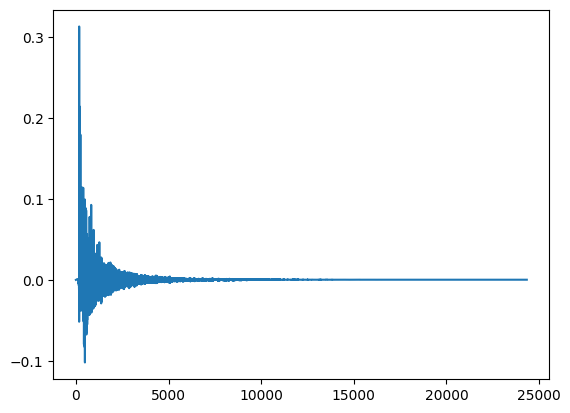

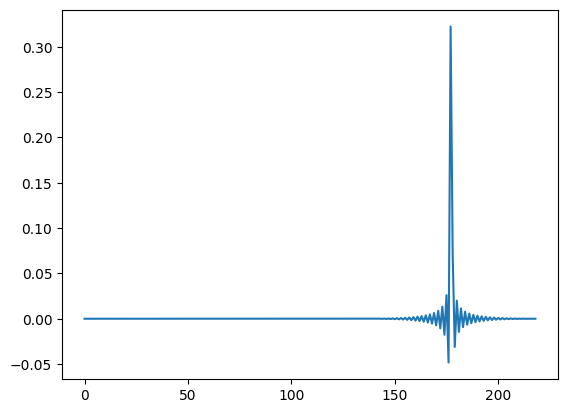

(8, 128000)
(128000,)
noisy[0] shape=(128000,)


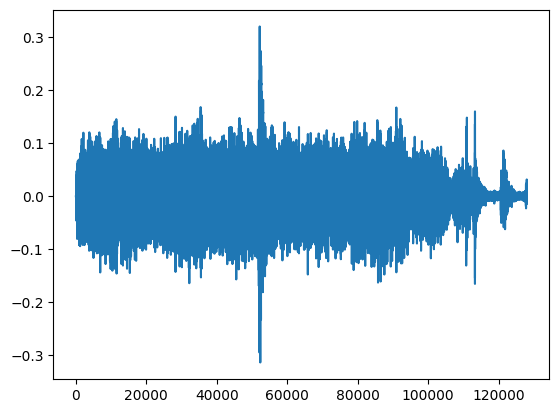

clean shape=(128000,)


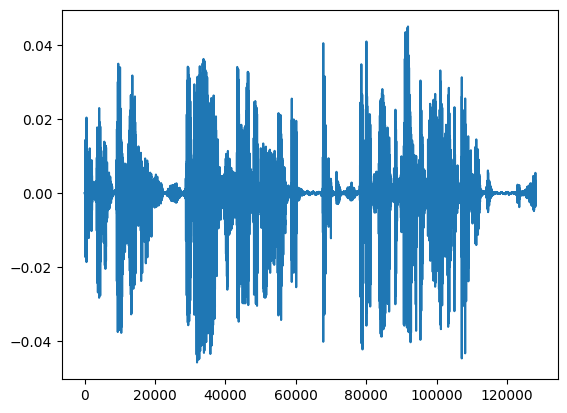

In [89]:
def show_audio(audio,fs,name):
    print(f'{name} shape={audio.shape}')
    plt.plot(audio)
    plt.show()
    IPython.display.display(IPython.display.Audio(audio, rate=fs))
    
plt.plot(room.rir[0][0])
plt.show()
plt.plot(freefield.rir[0][0])
plt.show()
print(noisy.shape)
print(clean.shape)
show_audio(noisy[0],fs,'noisy[0]')
show_audio(clean,fs,'clean')

In [ ]:

show_audio(clean,fs,'clean')
show_audio(noisy[0],fs,'noisy[0]')
show_audio(noisy[0]-clean,fs,'noisy[0]-clean')


## Generate val samples

We only generate validation samples while training samples are generated online.

In [ ]:
import pickle
from tqdm import tqdm

data_val_root = '/data2/zhouchang/datasets/mcse_val'
if not os.path.exists(data_val_root):
    os.makedirs(data_val_root)
    
noisy_val_root = os.path.join(data_val_root,'noisy')
if not os.path.exists(noisy_val_root):
    os.makedirs(noisy_val_root)
    
clean_val_root = os.path.join(data_val_root,'clean')
if not os.path.exists(clean_val_root):
    os.makedirs(clean_val_root)
    
meta_val_root = os.path.join(data_val_root,'meta')
if not os.path.exists(meta_val_root):
    os.makedirs(meta_val_root)

def write_meta(meta_root,name):
    with open(os.path.join(meta_root,f'{name}.pickle'),'wb') as f:
        pickle.dump(meta,f)

def load_meta(meta_root,name):
    with open(os.path.join(meta_root,f'{name}.pickle'),'rb') as f:
        loaded_meta = pickle.load(f)
    return loaded_meta

def write_audio(audio, fs, path):
    audio = np.clip(audio,-1,1)*np.iinfo(np.int16).max-1
    wavfile.write(path, fs, audio.astype(np.int16))

clip_seconds = 8
print(fs)
for i in tqdm(range(len(cleans_val))):
    clean = cleans_val[i]
    meta, room, freefield, noisy, clean = generate_random_noisy_for_speech(opt, clip_seconds, clean, noises_val, clean_root, noise_root)
    name = f'{i:04}'
    write_meta(meta_val_root,name)
    write_audio(noisy.T,fs,os.path.join(noisy_val_root,f'{name}.wav'))
    write_audio(clean,fs,os.path.join(clean_val_root,f'{name}.wav'))
    

    